In [1]:
using Revise
using MendelIHT
using SnpArrays
using Random
using GLM
using DelimitedFiles
using Test
using Distributions
using LinearAlgebra
using CSV
using DataFrames
using StatsBase
using TraitSimulation
using BenchmarkTools
BLAS.set_num_threads(1) # remember to set BLAS threads to 1 !!!

┌ Info: Precompiling MendelIHT [921c7187-1484-5754-b919-5d3ed9ac03c4]
└ @ Base loading.jl:1317


# Simple multivariate Gaussian traits

With $r$ traits, each sample's phenotype $\mathbf{y}_{i} \in \mathbb{R}^{n \times 1}$ is simulated under

$$\mathbf{y}_{i}^{r \times 1} \sim N(\mathbf{B}^{r \times p}\mathbf{x}_{i}^{p \times 1}, \ \ \Sigma_{r \times r})$$

This model assumes each sample is independent.

In [64]:
n = 1000  # number of samples
p = 10000 # number of SNPs
q = 100     # number of nongenetic covariates
k = 10    # number of causal SNPs
r = 2     # number of traits

# set random seed for reproducibility
Random.seed!(2021)

# simulate `.bed` file with no missing data
x = simulate_random_snparray("multivariate_$(r)traits.bed", n, p)
xla = SnpLinAlg{Float64}(x, model=ADDITIVE_MODEL, impute=false, center=true, scale=true) 

# nongenetic covariates; intercept is the 1st column
z = randn(n, q)
z[:, 1] .= 1
c = randn(q, r)

# simulate response y, true model b, and the correct non-0 positions of b
Y, true_Σ, true_b, correct_position = simulate_random_response(xla, k, r, Zu=z*c, overlap=0);

In [3]:
# save true SNP's position and effect size
open("multivariate_$(r)traits_true_beta.txt", "w") do io
    println(io, "snpID,effectsize")
    for pos in correct_position
        println(io, "snp$pos,", true_b[pos])
    end
end

# create `.bim` and `.bam` files using phenotype
make_bim_fam_files(x, Y, "multivariate_$(r)traits")

# save phenotypes in separate file
open("multivariate_$(r)traits.phen", "w") do io
    println(io, "FID\tIID\tT1\tT2")
    for i in 1:n
        println(io, "$i\t1\t", Y[i, 1], "\t", Y[i, 2])
    end
end

## Run IHT

In [65]:
Yt = Matrix(Y')
Zt = Matrix(z')
@time result = fit_iht(Yt, Transpose(xla), Zt, k=7, init_beta=true)

****                   MendelIHT Version 1.4.1                  ****
****     Benjamin Chu, Kevin Keys, Chris German, Hua Zhou       ****
****   Jin Zhou, Eric Sobel, Janet Sinsheimer, Kenneth Lange    ****
****                                                            ****
****                 Please cite our paper!                     ****
****         https://doi.org/10.1093/gigascience/giaa044        ****

Initializing β to univariate regression values...
...completed in 0.1 seconds.

Running sparse Multivariate Gaussian regression
Number of threads = 8
Link functin = IdentityLink()
Sparsity parameter (k) = 7
Prior weight scaling = off
Doubly sparse projection = off
Debias = off
Max IHT iterations = 200
Converging when tol < 0.0001 and iteration ≥ 5:

Iteration 1: loglikelihood = -3239.8589067406742, backtracks = 0, tol = 0.4427892095041617
Iteration 2: loglikelihood = -2731.7061210910415, backtracks = 0, tol = 0.16754168717279966
Iteration 3: loglikelihood = -2550.5673137871936, 


Compute time (sec):     0.3265831470489502
Final loglikelihood:    -2420.1022538427105
Iterations:             32
Trait 1's SNP PVE:      0.951081145560398
Trait 2's SNP PVE:      0.949788317267863

Estimated trait covariance:
2×2 DataFrame
 Row │ trait1   trait2  
     │ Float64  Float64 
─────┼──────────────────
   1 │ 5.79457  3.63796
   2 │ 3.63796  5.23835

Trait 1: IHT estimated 4 nonzero SNP predictors
4×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │      261    -0.623136
   2 │     2577     0.499328
   3 │     4767    -2.06477
   4 │     7654     1.0611

Trait 1: IHT estimated 100 non-genetic predictors
100×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │        1   1.98407
   2 │        2   0.204885
   3 │        3   0.778876
   4 │        4  -0.448998
   5 │        5   1.04494
   6 │        6   1.62274
   7 │        7  -1.47625
   8 │        8   0.550586


## Check answer

In [66]:
# first beta
β1 = result.beta[1, :]
true_b1_idx = findall(!iszero, true_b[:, 1])
[β1[true_b1_idx] true_b[true_b1_idx, 1]]

6×2 Matrix{Float64}:
 -0.623136  -0.606503
  0.0       -0.0973917
  0.499328   0.584764
 -2.06477   -2.13538
  1.0611     1.0853
  0.0       -0.242309

In [67]:
# second beta
β2 = result.beta[2, :]
true_b2_idx = findall(!iszero, true_b[:, 2])
[β2[true_b2_idx] true_b[true_b2_idx, 2]]

4×2 Matrix{Float64}:
  0.522538   0.592383
  0.0        0.363792
 -1.22943   -1.2704
  0.0       -0.10426

In [68]:
# non genetic covariates
[vec(result.c) vec(c')]

200×2 Matrix{Float64}:
  1.98407     2.04426
 -1.21446    -1.1548
  0.204885    0.411928
 -0.604014   -0.471283
  0.778876    0.873763
  0.0585358   0.110743
 -0.448998   -0.438718
  0.0868805   0.133405
  1.04494     1.14307
 -1.5798     -1.50455
  1.62274     1.57622
 -0.464744   -0.535578
 -1.47625    -1.43399
  ⋮          
  1.41426     1.35095
 -1.38466    -1.50165
 -1.48869    -1.47478
  0.381183    0.446708
  0.130512    0.0020513
  0.892373    0.786244
 -0.435264   -0.463497
  1.00259     0.966965
  0.739788    0.797359
  0.395847    0.310934
  1.94191     1.93984
 -0.421653   -0.359157

In [69]:
# covariance matrix
[vec(result.Σ) vec(true_Σ)]

4×2 Matrix{Float64}:
 5.79457  6.2004
 3.63796  4.0208
 3.63796  4.0208
 5.23835  5.67545

In [70]:
# number of causal SNPs recovered
correct_snps = [x[1] for x in correct_position]             # truely causal snps
signif_snps = findall(!iszero, β1) ∪ findall(!iszero, β2)   # IHT's selected snps
signif_snps ∩ correct_snps

6-element Vector{Int64}:
  261
 2577
 4767
 7654
  540
 4545

## Test Cross validation

In [45]:
Threads.nthreads()

8

In [46]:
Random.seed!(2020)
Yt = Matrix(Y')
Zt = Matrix(z')
@time mses = cv_iht(Yt, Transpose(xla), Zt, path=0:20, init_beta=false);

****                   MendelIHT Version 1.4.1                  ****
****     Benjamin Chu, Kevin Keys, Chris German, Hua Zhou       ****
****   Jin Zhou, Eric Sobel, Janet Sinsheimer, Kenneth Lange    ****
****                                                            ****
****                 Please cite our paper!                     ****
****         https://doi.org/10.1093/gigascience/giaa044        ****



Cross validating...100%|████████████████████████████████| Time: 0:00:03




Crossvalidation Results:
	k	MSE
	0	6469.203609848057
	1	2880.5248080533443
	2	2406.5255243578495
	3	2330.6608973836264
	4	2256.195685565707
	5	2193.4425949268725
	6	2144.320400354542
	7	2088.9197304282193
	8	2119.9961586628438
	9	2137.165024214338
	10	2156.800352576463
	11	2171.843435468765
	12	2202.541467918831
	13	2213.3907734937015
	14	2224.491848519913
	15	2253.5509913201836
	16	2256.1255203769924
	17	2227.789366736381
	18	2250.4551542593354
	19	2273.8809156024035
	20	2262.161085627236

Best k = 7

  4.630256 seconds (7.98 M allocations: 684.319 MiB, 2.77% gc time)


In [47]:
Random.seed!(2020)
Yt = Matrix(Y')
Zt = Matrix(z')
@time mses = cv_iht(Yt, Transpose(xla), Zt, path=0:20, init_beta=true);

****                   MendelIHT Version 1.4.1                  ****
****     Benjamin Chu, Kevin Keys, Chris German, Hua Zhou       ****
****   Jin Zhou, Eric Sobel, Janet Sinsheimer, Kenneth Lange    ****
****                                                            ****
****                 Please cite our paper!                     ****
****         https://doi.org/10.1093/gigascience/giaa044        ****



Cross validating...100%|████████████████████████████████| Time: 0:00:08




Crossvalidation Results:
	k	MSE
	0	4834.866700030927
	1	2880.521175990194
	2	2406.5280839532666
	3	2330.6616574229197
	4	2256.197058928352
	5	2193.453496654248
	6	2144.325277416228
	7	2088.9213366500476
	8	2117.8833693852644
	9	2128.4472613034945
	10	2165.517781225008
	11	2175.233272262217
	12	2182.878605121384
	13	2204.344947281428
	14	2213.0563673176975
	15	2230.0505108855705
	16	2236.201538232794
	17	2250.1174700466236
	18	2263.987299591203
	19	2301.466032165297
	20	2302.024784259434

Best k = 7

  8.495308 seconds (6.37 M allocations: 13.192 GiB, 29.06% gc time)


# GEMMA multivariate results

In [84]:
gemma_df = CSV.read("gemma.result.assoc.txt", DataFrame)

# pvalues
pval_wald = gemma_df[!, :p_wald]
pval_lrt = gemma_df[!, :p_lrt]
pval_score = gemma_df[!, :p_score]

# estimated beta
estim_β1 = gemma_df[!, :beta_1]
estim_β2 = gemma_df[!, :beta_2]

# estimated covariance matrix
estim_σ11 = gemma_df[!, :Vbeta_1_1]
estim_σ12 = gemma_df[!, :Vbeta_1_2]
estim_σ22 = gemma_df[!, :Vbeta_2_2];

correct_snps = [x[1] for x in correct_position]  # truely causal snps
signif_snps = findall(x -> x ≤ 0.05/p, pval_lrt) # gemma's selected snps
signif_snps ∩ correct_snps

6-element Array{Int64,1}:
 2110
 5375
 5797
 6015
 6813
 8087

**Conclusion:** GEMMA finds 6/10 causal SNPs

# MV-PLINK

In [25]:
mvplink_df = CSV.read("plink.mqfam.total", DataFrame, delim=' ', ignorerepeated=true)

# pvalues
pval = mvplink_df[!, :P]

# SNPs passing threshold
signif_snps = findall(x -> x ≤ 0.05 / p, pval)
signif_snps ∩ correct_snps

6-element Array{Int64,1}:
 2110
 5375
 5797
 6015
 6813
 8087

**Conclusion:** MV-PLINK finds 6/10 causal SNPs

# More complicated simulations (multivariate traits)

Let us simulate:
+ Non-independent samples
+ Polygenic traits where every SNP contributes to the phenotype, but $k$ SNPs have large effect

For $r$ traits, our model is:

$$\mathbf{Y}_{r \times n} \sim \text{MatrixNormal}(\mathbf{B}_{r \times p}\mathbf{X}_{p \times n}, \ \ \Sigma_{r \times r} , \ \ \sigma_g^2\Phi_{n \times n} + \sigma_e^2 \mathbf{I}_{n \times n})$$

where
+ $\mathbf{X}_{p \times n}$ contains *all* predictors (genetic + non-genetic)
+ $\mathbf{B}_{r \times p}$ contains (true) regression coefficients. $k$ entries are non-zero
+ $\Sigma_{r \times r}$ is the row (trait) covariance matrix
+ $\sigma_g^2\Phi_{n \times n} + \sigma_e^2 \mathbf{I}_{n \times n}$ is the column (sample) covariance matrix
+ $\Phi$ is the GRM estimated from the genotypes
+ $\sigma_g^2 = 0.6$ and $\sigma_e^2 = 0.4$ (thus heritability is 60%)

In [ ]:
n = 1000  # number of samples
p = 10000 # number of SNPs
k = 10    # number of causal SNPs
r = 2     # number of traits

# set random seed for reproducibility
Random.seed!(111)

# simulate `.bed` file with no missing data
x = simulate_random_snparray("multivariate_$(r)traits.bed", n, p)
xla = SnpLinAlg{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true) 

# intercept is the only nongenetic covariate
z = ones(n, 1)
intercepts = [0.5 1.0] # each trait have different intercept

# simulate β
B = zeros(p, r)
B[1:k] .= randn(k)
shuffle!(B)

# between trait covariance matrix
Σ = random_covariance_matrix(r)

# between sample covariance is identity + GRM (2 times because in SnpArrays grm is halved)
Φ = 2grm(x)
σg = 0.6
σe = 0.4
V = σg * Φ + σe * I

# simulate y using TraitSimulations.jl (https://github.com/OpenMendel/TraitSimulation.jl/blob/master/src/modelframework.jl#L137)
vc = @vc Σ ⊗ V
μ = zeros(n, r)
μ_null = zeros(n, r)
LinearAlgebra.mul!(μ_null, z, intercepts)
mul!(μ, xla, B)
BLAS.axpby!(1.0, μ_null, 1.0, μ)
VCM_model = VCMTrait(z, intercepts, xla, B, vc, μ)
Y = Matrix(Transpose(simulate(VCM_model)))

# simulate using naive model
# μ = z * intercepts + xla * B
# Yt = rand(MatrixNormal(μ', Σ, V))

In [42]:
# create `.bim` and `.bam` files using phenotype
make_bim_fam_files(x, Transpose(Yt), "multivariate_$(r)traits")

# save phenotypes in separate file
open("multivariate_$(r)traits.phen", "w") do io
    println(io, "FID\tIID\tT1\tT2")
    for i in 1:n
        println(io, "$i\t1\t", Yt[1, i], "\t", Yt[2, i])
    end
end

## Run IHT 

In [14]:
Zt = Matrix(z')
ktrue = k + count(!iszero, intercepts)
@time result = fit_iht(Y, Transpose(xla), Zt, k=18, verbose=true)

****                   MendelIHT Version 1.4.0                  ****
****     Benjamin Chu, Kevin Keys, Chris German, Hua Zhou       ****
****   Jin Zhou, Eric Sobel, Janet Sinsheimer, Kenneth Lange    ****
****                                                            ****
****                 Please cite our paper!                     ****
****         https://doi.org/10.1093/gigascience/giaa044        ****

Running sparse Multivariate Gaussian regression
Link functin = IdentityLink()
Sparsity parameter (k) = 18
Prior weight scaling = off
Doubly sparse projection = off
Debias = off
Max IHT iterations = 200
Converging when tol < 0.0001:

Iteration 1: loglikelihood = -157.43077016659845, backtracks = 0, tol = 0.2144494664199513
Iteration 2: loglikelihood = 1649.4627458274367, backtracks = 0, tol = 0.029644152665055448
Iteration 3: loglikelihood = 2306.900854511885, backtracks = 0, tol = 0.0048972266751546025
Iteration 4: loglikelihood = 2420.707164168618, backtracks = 0, tol = 0.00273


Compute time (sec):     3.3496580123901367
Final loglikelihood:    3337.135413598977
Iterations:             34
Trait 1's SNP PVE:      0.40781437818627647
Trait 2's SNP PVE:      0.9184458100359857

Trait 1: IHT estimated 8 nonzero SNP predictors
8×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │      394    0.0149745
   2 │      653    0.0157326
   3 │     1138    0.0181775
   4 │     2529   -0.238531
   5 │     2872    0.799547
   6 │     4248   -1.41112
   7 │     4457    0.0135361
   8 │     8921    1.09215

Trait 1: IHT estimated 1 non-genetic predictors
1×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │        1     0.545089

Trait 2: IHT estimated 8 nonzero SNP predictors
8×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │     2192   -0.0141054
   2 │     3750   -0.0137672
   3 │     4710   -0.11437
 

In [15]:
# first beta
β1 = result.beta[1, :]
true_b1_idx = findall(!iszero, B[:, 1])
[β1[true_b1_idx] B[true_b1_idx, 1]]

5×2 Array{Float64,2}:
 -0.238531  -0.413412
  0.799547   0.811243
  0.0        0.0244199
 -1.41112   -1.42827
  1.09215    1.24969

In [16]:
# second beta
β2 = result.beta[2, :]
true_b2_idx = findall(!iszero, B[:, 2])
[β2[true_b2_idx] B[true_b2_idx, 2]]

5×2 Array{Float64,2}:
  0.0       -0.0597678
 -0.11437   -0.11578
 -2.70962   -2.70844
 -0.265224  -0.212269
  0.311396   0.310274

In [7]:
# non genetic covariates
[result.c intercepts']

2×2 Array{Float64,2}:
  0.545089   0.5
 10.0167    10.0

In [8]:
# covariance matrix
[vec(result.Σ) vec(Σ)]

4×2 Array{Float64,2}:
 5.97584   5.65059
 2.10382   1.97568
 2.10382   1.97568
 0.752572  0.702678

In [9]:
# number of causal SNPs recovered
correct_position = findall(!iszero, B)
correct_snps = [x[1] for x in correct_position]             # truely causal snps
signif_snps = findall(!iszero, β1) ∪ findall(!iszero, β2)   # IHT's selected snps
signif_snps ∩ correct_snps

7-element Array{Int64,1}:
 2529
 2872
 4248
 8921
 4710
 6991
 8964

In [13]:
# 4 cores
Random.seed!(2020)
@time mses = cv_iht(Yt, Transpose(xla), Zt, path=1:20, parallel=true);

Cross validating...100%|████████████████████████████████| Time: 0:00:11




Crossvalidation Results:
	k	MSE
	1	3640.903878187202
	2	5136.743455625588
	3	1863.1948066249706
	4	1670.4731329049519
	5	1545.0302734109982
	6	1479.4239614780086
	7	1481.4458591080859
	8	1490.3409149877882
	9	1462.718430332951
	10	1466.086676084636
	11	1457.4576808962279
	12	1441.3324810398728
	13	1438.546205290451
	14	1429.6885863820098
	15	1400.8436416671896
	16	1393.7121458656584
	17	1393.0616799444094
	18	1392.61421066748
	19	1395.4624808788124
	20	1398.0522212072035

Best k = 18

 11.774955 seconds (127.80 k allocations: 13.032 MiB, 0.19% gc time)


## GEMMA multivariate results

We use the wald test statistics. The likelihood ratio p-values are all 1.0 or 0.0, so there's some problems with it. 

In [35]:
"""
Computes power and false positive rates
- p: total number of SNPs
- correct_snps: Indices of the true causal SNPs
- detected_snps: Indices of SNPs that are significant after testing
"""
function power_and_fpr(p::Int, correct_snps::Vector{Int}, detected_snps::Vector{Int})
    power = length(detected_snps ∩ correct_snps) / length(correct_snps)
    FP = length(detected_snps) - length(detected_snps ∩ correct_snps) # number of false positives
    TN = p - length(detected_snps) # number of true negatives
    FPR = FP / (FP + TN)
    return power, FP, FPR
end

power_and_fpr

In [83]:
gemma_df = CSV.read("gemma.polygenic.result.assoc.txt", DataFrame)
correct_position = findall(!iszero, B)

# pvalues
pval_wald = gemma_df[!, :p_wald]
pval_lrt = gemma_df[!, :p_lrt]
pval_score = gemma_df[!, :p_score]

# estimated beta
estim_β1 = gemma_df[!, :beta_1]
estim_β2 = gemma_df[!, :beta_2]

# estimated covariance matrix
estim_σ11 = gemma_df[!, :Vbeta_1_1]
estim_σ12 = gemma_df[!, :Vbeta_1_2]
estim_σ22 = gemma_df[!, :Vbeta_2_2];

# check how many real SNPs were recovered
correct_snps = [x[1] for x in correct_position]  # truely causal snps
signif_snps = findall(x -> x ≤ 0.05/p, pval_wald) # gemma's selected snps
@show signif_snps ∩ correct_snps

# compute power, false positives, and false positive rate
power_and_fpr(p, correct_snps, signif_snps)

signif_snps ∩ correct_snps = [2529, 2872, 4248, 6991, 8921]


(0.5, 0, 0.0)

## MV-PLINK

In [82]:
mvplink_df = CSV.read("plink.mqfam.polygenic.total", DataFrame, delim=' ', ignorerepeated=true)

# pvalues
pval = mvplink_df[!, :P]

# SNPs passing threshold
signif_snps = findall(x -> x ≤ 0.05 / p, pval)
@show signif_snps ∩ correct_snps

# compute power, false positives, and false positive rate
power_and_fpr(p, correct_snps, signif_snps)

signif_snps ∩ correct_snps = [2529, 2872, 4248, 6991, 8921]


(0.5, 0, 0.0)

# Conclusion

+ MV-PLINK and IHT run in seconds, GEMMA runs in minutes ~ hours
+ Multivariate IHT's beta estimates are precise, under both truly sparse or polygenic model.
+ With polygenic model, IHT finds more true SNPs but also has higher false positive rate. 
+ In a separate simulation with 5k samples and 300k SNPs, IHT's cross validation takes roughly 1.5h on 8 cores. 

# Large scale simulation

The code below is meant for running on Hoffman2 cluster.

In [13]:
using Distributed
addprocs(8)

@everywhere using Revise
@everywhere using MendelIHT
@everywhere using SnpArrays
@everywhere using Random
@everywhere using GLM
@everywhere using DelimitedFiles
@everywhere using Distributions
@everywhere using LinearAlgebra
@everywhere using CSV
@everywhere using DataFrames
@everywhere using StatsBase
@everywhere using TraitSimulation

"""
k = Number of causal SNPs
p = Total number of SNPs
traits = Number of traits (phenotypes)
overlap = number of causal SNPs shared in each trait
"""
function simulate_random_beta(k::Int, p::Int, traits::Int; overlap::Int=0, βσ=1.0)
    d = Normal(0, βσ)
    true_b = zeros(p, traits)
    if overlap == 0
        causal_snps = sample(1:(traits * p), k, replace=false)
        true_b[causal_snps] = rand(d, k)
    else
        shared_snps = sample(1:p, overlap, replace=false)
        weight_vector = aweights(1 / (traits * (p - overlap)) * ones(traits * p))
        for i in 1:traits
            weight_vector[i*shared_snps] .= 0.0 # avoid sampling from shared snps
        end
        @assert sum(weight_vector) ≈ 1.0
        # simulate β for shared predictors
        for i in 1:traits
            true_b[shared_snps, i] = rand(d, overlap)
        end
        # simulate β for none shared predictors
        nonshared_snps = sample(1:(traits * p), weight_vector, k - (traits * overlap), replace=false)
        true_b[nonshared_snps] = rand(d, k - (traits * overlap))
    end

    return true_b
end

"""
# Arguments
xla = simulated genotype matrix (converted to a SnpLinAlg)
k = number of causal SNPs
r = number of traits
Φ = estimated GRM (using GEMMA)

# Optional arguments
seed = random seed for reproducibility
σ2 = contribution of GRM
σe = random environmental effect
βoverlap = number of causal SNPs shared in all traits
"""
function simulate_multivariate_polygenic(
    plinkname::String, n::Int, p::Int, k::Int, r::Int;
    seed::Int=2021, σg=0.6, σe=0.4, βoverlap=2, βσ=1.0
    )
    # set seed
    Random.seed!(seed)
    
    # simulate `.bed` file with no missing data
    x = simulate_random_snparray("sim$seed/" * plinkname * ".bed", n, p)
    xla = SnpLinAlg{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true)
    
    # intercept is the only nongenetic covariate
    Z = ones(n, 1)
    intercepts = randn(r)' # each trait have different intercept

    # simulate β
    B = simulate_random_beta(k, p, r, overlap=βoverlap, βσ=βσ)
    writedlm("sim$(seed)/trueb.txt", B)

    # between trait covariance matrix
    Σ = random_covariance_matrix(r)

    # between sample covariance is identity + GRM (2x because OpenMendel always uses half the GRM)
    Φ = 2grm(x, method=:Robust)
    writedlm("sim$seed/$plinkname.grm", Φ)
    V = σg * Φ + σe * I

    # simulate y using TraitSimulations.jl (https://github.com/OpenMendel/TraitSimulation.jl/blob/master/src/modelframework.jl#L137)
    vc = @vc Σ ⊗ V
    μ = zeros(n, r)
    μ_null = zeros(n, r)
    LinearAlgebra.mul!(μ_null, Z, intercepts)
    mul!(μ, xla, B)
    BLAS.axpby!(1.0, μ_null, 1.0, μ)
    VCM_model = VCMTrait(Z, intercepts, xla, B, vc, μ)
    Y = Matrix(Transpose(simulate(VCM_model)))

    # simulate using Distributions.jl
    # μ = z * intercepts + xla * B
    # Y = rand(MatrixNormal(μ', Σ, V))
    
    return xla, Matrix(Z'), B, Σ, Y
end

function simulate_multivariate_sparse(
    plinkname::String, n::Int, p::Int, k::Int, r::Int;
    seed::Int=2021, σg=0.6, σe=0.4, βoverlap=2, 
    )
    # set seed
    Random.seed!(seed)
    
    # simulate `.bed` file with no missing data
    x = simulate_random_snparray("sim$seed/" * plinkname * ".bed", n, p)
    xla = SnpLinAlg{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true)
    n, p = size(x)

    # intercept is the only nongenetic covariate
    z = ones(n, 1)
    intercepts = randn(r)' # each trait have different intercept

    # simulate response y, true model b, and the correct non-0 positions of b
    Y, true_Σ, true_b, correct_position = simulate_random_response(xla, k, r, Zu=z*intercepts, overlap=2);
    
    return xla, Matrix(z'), true_b, true_Σ, Matrix(Y')
end

function simulate_NFBC1966_sparse(
    plinkname::String, k::Int, r::Int;
    seed::Int=2021, σg=0.6, σe=0.4, βoverlap=2, βσ = 1.0
    )
    # set seed
    Random.seed!(seed)
    
    # simulate `.bed` file with no missing data
    x = SnpArray(plinkname * ".bed")
    xla = SnpLinAlg{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true)
    n, p = size(xla)
    
    # intercept is the only nongenetic covariate
    Z = ones(n, 1)
    intercepts = randn(r)' # each trait have different intercept

    # simulate β
    B = simulate_random_beta(k, p, r, overlap=βoverlap, βσ=βσ)
    writedlm("sim$(seed)/trueb.txt", B)

    # between trait covariance matrix
    Σ = random_covariance_matrix(r)
    
    # simulate multivariate normal phenotype for each sample
    μ = xla * B + Z*intercepts

    # simulate response
    Y = zeros(n, r)
    for i in 1:n
        μi = @view(μ[i, :])
        Y[i, :] = rand(MvNormal(μi, Σ))
    end
    
    return xla, Matrix(Z'), B, Σ, Matrix(Y')
end

function simulate_NFBC1966_polygenic(
    plinkname::String, k::Int, r::Int;
    seed::Int=2021, σg=0.6, σe=0.4, βoverlap=2, βσ=1.0,
    )
    # set seed
    Random.seed!(seed)
    
    # simulate `.bed` file with no missing data
    x = SnpArray(plinkname * ".bed")
    xla = SnpLinAlg{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true)
    n, p = size(x)
    
    # intercept is the only nongenetic covariate
    Z = ones(n, 1)
    intercepts = randn(r)' # each trait have different intercept

    # simulate β
    B = simulate_random_beta(k, p, r, overlap=βoverlap, βσ=βσ)
    writedlm("sim$(seed)/trueb.txt", B)

    # between trait covariance matrix
    Σ = random_covariance_matrix(r)
    writedlm("sim$(seed)/true_cov.txt", Σ)

    # between sample covariance is identity + GRM
    Φ = readdlm(plinkname * ".cXX.txt")
    V = σg * Φ + σe * I

    # simulate y using TraitSimulations.jl (https://github.com/OpenMendel/TraitSimulation.jl/blob/master/src/modelframework.jl#L137)
    vc = @vc Σ ⊗ V
    μ = zeros(n, r)
    μ_null = zeros(n, r)
    LinearAlgebra.mul!(μ_null, Z, intercepts)
    mul!(μ, xla, B)
    BLAS.axpby!(1.0, μ_null, 1.0, μ)
    VCM_model = VCMTrait(Z, intercepts, xla, B, vc, μ)
    Y = Matrix(Transpose(simulate(VCM_model)))

    # simulate using Distributions.jl
    # μ = z * intercepts + xla * B
    # Y = rand(MatrixNormal(μ', Σ, V))
    
    return xla, Matrix(Z'), B, Σ, Y
end

function make_bim_file(x::SnpLinAlg, name::String)
    p = size(x, 2)

    #create .bim file structure: https://www.cog-genomics.org/plink2/formats#bim
    open(name * ".bim", "w") do f
        for i in 1:p
            write(f, "1\tsnp$i\t0\t1\t1\t2\n")
        end
    end
end

function make_GEMMA_fam_file(x::SnpLinAlg, y::AbstractVecOrMat, name::String)
    ly = size(y, 1)
    n, p = size(x)

    # put 1st phenotypes in 6th column, 2nd phenotype in 7th column ... etc
    traits = size(y, 1)
    open(name * ".fam", "w") do f
        for i in 1:n
            write(f, "$i\t1\t0\t0\t1")
            for j in 1:traits
                write(f, "\t$(y[j, i])")
            end
            write(f, "\n")
        end
    end
end

function make_MVPLINK_fam_and_phen_file(x::SnpLinAlg, y::AbstractVecOrMat, name::String)
    ly = size(y, 1)
    n, p = size(x)

    # put a random phenotype in fam file
    traits = size(y, 1)
    open(name * ".fam", "w") do f
        for i in 1:n
            println(f, "$i\t1\t0\t0\t1\t1")
        end
    end

    # save phenotypes in separate `.phen` file
    open(name * ".phen", "w") do io
        print(io, "FID\tIID")
        for j in 1:traits
            print(io, "\tT$j")
        end
        print(io, "\n")
        for i in 1:n
            print(io, "$i\t1")
            for j in 1:traits
                write(io, "\t$(y[j, i])")
            end
            print(io, "\n")
        end
    end
end

"""
Computes power and false positive rates
- p: total number of SNPs
- correct_snps: Indices (or ID) of the true causal SNPs
- detected_snps: Indices (or ID) of SNPs that are significant after testing

returns: power, number of false positives, and false positive rate
"""
function power_and_fpr(p::Int, correct_snps::Vector, signif_snps::Vector)
    power = length(signif_snps ∩ correct_snps) / length(correct_snps)
    FP = length(signif_snps) - length(signif_snps ∩ correct_snps) # number of false positives
    TN = p - length(signif_snps) # number of true negatives
    FPR = FP / (FP + TN)
    return power, FP, FPR
end

"""
- filename: gemma's output file name
- correct_snps: indices for real causal SNPs

returns: power, number of false positives, and false positive rate
"""
function process_gemma_result(filename, correct_snpid)
    # read GEMMA result
    gemma_df = CSV.read(filename, DataFrame)
    snps = size(gemma_df, 1)

    # pvalues
    pval_wald = gemma_df[!, :p_wald]
#    pval_lrt = gemma_df[!, :p_lrt]
#     pval_score = gemma_df[!, :p_score]

    # estimated beta
#     estim_β1 = gemma_df[!, :beta_1]
#     estim_β2 = gemma_df[!, :beta_2]

#     # estimated covariance matrix
#     estim_σ11 = gemma_df[!, :Vbeta_1_1]
#     estim_σ12 = gemma_df[!, :Vbeta_1_2]
#     estim_σ22 = gemma_df[!, :Vbeta_2_2];

    # check how many real SNPs were recovered
    signif_snps = findall(x -> x ≤ 0.05 / snps, pval_wald) # gemma's selected snps
    signif_snpid = gemma_df[signif_snps, :rs]

    # compute power, false positives, and false positive rate
    power_and_fpr(snps, correct_snpid, signif_snpid)
end

"""
- filename: mvPLINK's output file name
- correct_snps: indices for real causal SNPs

returns: power, number of false positives, and false positive rate
"""
function process_mvPLINK(filename, correct_snps)
    # read mvPLINK result
    mvplink_df = CSV.read(filename, DataFrame, delim=' ', ignorerepeated=true)
    snps = size(mvplink_df, 1)

    # get pvalues, possibly accounting for "NA"s
    if eltype(mvplink_df[!, :P]) == Float64
        pval = mvplink_df[!, :P]
    else
        mvplink_df[findall(x -> x == "NA", mvplink_df[!, :P]), :P] .= "1.0"
        pval = parse.(Float64, mvplink_df[!, :P])
    end

    # SNPs passing threshold
    signif_snps = findall(x -> x ≤ 0.05 / snps, pval)

    # compute power, false positives, and false positive rate
    power_and_fpr(snps, correct_snps, signif_snps)
end

"""
# Arguments
n = number of samples
p = number of SNPs
k = number of causal SNPs
r = number of traits

# Optional arguments
seed = random seed for reproducibility
σ2 = contribution of GRM
σe = random environmental effect
βoverlap = number of causal SNPs shared in all traits
"""
# function one_simulation(
#     n::Int, p::Int, k::Int, r::Int;
#     seed::Int=2021, σg=0.6, σe=0.4, βoverlap=2
#     )
#     isdir("sim$seed") || mkdir("sim$seed")
#     plinkname = "sim$(seed)_$(r)traits"
    
#     # simulate data
#     xla, Z, B, Σ, Y = simulate_multivariate_sparse(plinkname, n, p, k, r,
#         seed=seed, σg=σg, σe=σe, βoverlap=βoverlap)
#     correct_position = findall(!iszero, B)
#     correct_snps = unique([x[1] for x in correct_position])
#     make_bim_file(xla, "sim$(seed)/" * plinkname)
    
#     # run IHT
#     Random.seed!(seed)
#     iht_time = @elapsed begin
#         mses = cv_iht(Y, Transpose(xla), Z, parallel=true)
#         iht_result = fit_iht(Y, Transpose(xla), Z, k=argmin(mses))
#     end
#     β1, β2 = iht_result.beta[1, :], iht_result.beta[2, :]
#     detected_snps = findall(!iszero, β1) ∪ findall(!iszero, β2)
#     iht_power, iht_FP, iht_FPR = power_and_fpr(size(B, 1), correct_snps, detected_snps)
#     writedlm("sim$(seed)/iht_beta1.txt", β1)
#     writedlm("sim$(seed)/iht_beta2.txt", β2)
#     println("IHT power = $iht_power, FP = $iht_FP, FPR = $iht_FPR")

#     # run MVPLINK
#     phenofile = "sim$(seed)/" * plinkname * ".phen"
#     outfile = "sim$(seed)/mvPLINK_sim$seed.mqfam.total"
#     make_MVPLINK_fam_and_phen_file(xla, Y, "sim$(seed)/" * plinkname)
#     mvplink_time = @elapsed run(`./plink.multivariate --bfile sim$(seed)/$plinkname --noweb --mult-pheno $phenofile --mqfam`)
#     mv("plink.mqfam.total", outfile, force=true)
#     mv("plink.log", "sim$(seed)/mvPLINK_sim$seed.log", force=true)
#     mvPLINK_power, mvPLINK_FP, mvPLINK_FPR = process_mvPLINK(outfile, correct_snps)
#     println("mvPLINK power = $mvPLINK_power, FP = $mvPLINK_FP, FPR = $mvPLINK_FPR")

#     # run GEMMA
#     make_GEMMA_fam_file(xla, Y, "sim$(seed)/" * plinkname)
#     gemma_time = @elapsed begin
#         run(`./gemma -bfile sim$(seed)/$plinkname -gk 1 -o $plinkname`)
#         run(`./gemma -bfile sim$(seed)/$plinkname -k output/$(plinkname).cXX.txt -maf 0.0001 -lmm 1 -n 1 2 -o gemma.sim$seed`)
#     end
#     gemma_power, gemma_FP, gemma_FPR = process_gemma_result("output/gemma.sim$seed.assoc.txt", correct_snps)
#     println("GEMMA power = $gemma_power, FP = $gemma_FP, FPR = $gemma_FPR")
#     mv("output/gemma.sim$seed.assoc.txt", "sim$(seed)/gemma.sim$seed.assoc.txt")
#     mv("output/gemma.sim$seed.log.txt", "sim$(seed)/gemma.sim$seed.log.txt")

#     # save summary stats
#     open("sim$(seed)/summary.txt", "w") do io
#         println(io, "Simulation $seed summary")
#         println(io, "n = $n, p = $p, k = $k, r = $r\n")
#         println(io, "IHT time = $iht_time seconds, power = $iht_power, FP = $iht_FP, FPR = $iht_FPR")
#         println(io, "mvPLINK time = $mvplink_time seconds, power = $mvPLINK_power, FP = $mvPLINK_FP, FPR = $mvPLINK_FPR")
#         println(io, "GEMMA time = $gemma_time seconds, power = $gemma_power, FP = $gemma_FP, FPR = $gemma_FPR")
#     end

#     return nothing
# end

function one_NFBC_simulation(
    k::Int, r::Int;
    seed::Int=2021, σg=0.6, σe=0.4, βoverlap=2, βσ = 1.0,
    path=1:20, init_beta=false, model=:polygenic, debias=false
    )
    cd("/u/scratch/b/biona001")
    isdir("sim$seed") || mkdir("sim$seed")
    plinkname = "NFBC_imputed_with_0"
    
    # simulate data
    Random.seed!(seed)
    if model == :polygenic
        xla, Z, B, Σ, Y = simulate_NFBC1966_polygenic(plinkname, k, r,
            seed=seed, σg=σg, σe=σe, βoverlap=βoverlap, βσ=βσ)
    elseif model == :sparse
        xla, Z, B, Σ, Y = simulate_NFBC1966_sparse(plinkname, k, r,
            seed=seed, σg=σg, σe=σe, βoverlap=βoverlap, βσ=βσ)
    else
        error("model should be :sparse or :polygenic")
    end
    correct_position = findall(!iszero, B)
    correct_snps = unique([x[1] for x in correct_position])
    correct_snp_rsid = SnpData(plinkname).snp_info[correct_snps, :snpid]
    
    # run GEMMA (GRM is precomputed already)
    cd("sim$seed")
    run(`cp ../NFBC_imputed_with_0.bed .`)
    run(`cp ../NFBC_imputed_with_0.bim .`)
    run(`cp ../NFBC_imputed_with_0.cXX.txt .`)
    make_GEMMA_fam_file(xla, Y, plinkname)
    pheno_columns = [string(ri) for ri in 1:r]
    gemma_time = @elapsed begin
        run(`../gemma -bfile $plinkname -k $(plinkname).cXX.txt -notsnp -lmm 1 -n $pheno_columns -o gemma.sim$seed`)
    end
    gemma_power, gemma_FP, gemma_FPR = process_gemma_result("output/gemma.sim$seed.assoc.txt", correct_snp_rsid)
    println("GEMMA power = $gemma_power, FP = $gemma_FP, FPR = $gemma_FPR")
    mv("output/gemma.sim$seed.assoc.txt", "gemma.sim$seed.assoc.txt")
    mv("output/gemma.sim$seed.log.txt", "gemma.sim$seed.log.txt")
        
    # run IHT
    iht_time = @elapsed begin
        mses = cross_validate(plinkname, MvNormal, path=path, phenotypes=collect(1:r).+5;
            init_beta=init_beta, debias=debias)
        iht_result = iht(plinkname, path[argmin(mses)], MvNormal, phenotypes=collect(1:r).+5;
            init_beta=init_beta, debias=debias)
    end
    detected_snps = Int[]
    for i in 1:r # save each beta separately
        β = iht_result.beta[i, :]
        detected_snps = detected_snps ∪ findall(!iszero, β)
        writedlm("iht_beta$i.txt", β)
    end
    iht_power, iht_FP, iht_FPR = power_and_fpr(size(B, 1), correct_snps, detected_snps)

    # run MVPLINK
    phenofile = plinkname * ".phen"
    make_MVPLINK_fam_and_phen_file(xla, Y, plinkname)
    mvplink_time = @elapsed run(`../plink.multivariate --bfile $plinkname --noweb --mult-pheno $phenofile --mqfam`)
    mvPLINK_power, mvPLINK_FP, mvPLINK_FPR = process_mvPLINK("plink.mqfam.total", correct_snps)
    println("mvPLINK power = $mvPLINK_power, FP = $mvPLINK_FP, FPR = $mvPLINK_FPR")
        
    # clean up
    rm("plink.hh", force=true)
    rm("NFBC_imputed_with_0.fam", force=true)
    rm("NFBC_imputed_with_0.bed", force=true)
    rm("NFBC_imputed_with_0.bim", force=true)
    rm("NFBC_imputed_with_0.cXX.txt", force=true)

    # save summary stats
    n, p = size(xla)
    open("summary.txt", "w") do io
        println(io, "Simulation $seed summary")
        println(io, "n = $n, p = $p, k = $k, r = $r\n")
        println(io, "IHT time = $iht_time seconds, power = $iht_power, FP = $iht_FP, FPR = $iht_FPR")
        println(io, "mvPLINK time = $mvplink_time seconds, power = $mvPLINK_power, FP = $mvPLINK_FP, FPR = $mvPLINK_FPR")
        println(io, "GEMMA time = $gemma_time seconds, power = $gemma_power, FP = $gemma_FP, FPR = $gemma_FPR")
    end

    return nothing
end

#
# NFBC1966 data (uses TraitSimulation.jl, q = 3, 20 cross validation paths)
# sim 1-50 are for k = 10, r = 2, βoverlap = 2 (polygenic model), β ~ N(0, 0.25)    
# sim 51-100 are for k = 10, r = 2, βoverlap = 2 (polygenic model), β ~ N(0, 0.1)    
# sim 101-150 are for k = 20, r = 2, βoverlap = 4 (polygenic model), β ~ N(0, 0.1)     (run.jl)
# sim 151-200 are for k = 50, r = 2, βoverlap = 10 (polygenic model), β ~ N(0, 0.1)     (run2.jl)
# sim 201-250 are for k = 100, r = 2, βoverlap = 20 (polygenic model), β ~ N(0, 0.1)     (run3.jl)
# sim 251-300 are for k = 10, r = 5, βoverlap = 1 (polygenic model), β ~ N(0, 0.1)     (run4.jl)
#
        
#
# NFBC1966 data (uses TraitSimulation.jl, q = 5, 20 cross validation paths, iterates ≥5 times)
# sim 301-325 are for k = 10, r = 2, βoverlap = 2 (polygenic model), β ~ N(0, 0.1) (init_beta=false, debias=false)
# sim 326-350 are for k = 10, r = 2, βoverlap = 2 (polygenic model), β ~ N(0, 0.1) (init_beta=false, debias=true)
# sim 401-425 are for k = 10, r = 2, βoverlap = 2 (sparse model), β ~ N(0, 0.1) (init_beta=false, debias=false)
# 

#
# NFBC1966 data (q = 5, polygenic model, iterates ≥5 times, init_beta=false, debias=false, β ~ N(0, 0.1))
# sim 1-20 are for k = 10, r = 2, βoverlap = 2, path = 1:20
# sim 21-40 are for k = 50, r = 2, βoverlap = 10, path = 5:5:100
# sim 41-60 are for k = 100, r = 2, βoverlap = 20, path = 10:10:200
# sim 61-80 are for k = 10, r = 5, βoverlap = 1, path = 1:20
# sim 81-100 are for k = 50, r = 5, βoverlap = 2, path = 5:5:100
# sim 101-120 are for k = 100, r = 5, βoverlap = 4, path = 10:10:200
#

βσ = 0.1
σg = 0.6
σe = 0.4
model = :polygenic
init_beta = false
debias = false

k = 10
r = 2
βoverlap = 2
path = 1:20

seed = parse(Int, ARGS[1])
one_NFBC_simulation(k, r, seed = seed, path = path, βoverlap=βoverlap, βσ = βσ,
    σg=σg, σe=σe, init_beta=init_beta, model=model)

true

In [13]:
function run_repeats(repeats::Int)
    for seed in 1:repeats
        # create .sh file to submit jobs
        open("run$seed.sh", "w") do io
            println(io, "#!/bin/bash")
            println(io, "#\$ -cwd")
            println(io, "# error = Merged with joblog")
            println(io, "#\$ -o joblog.\$JOB_ID")
            println(io, "#\$ -j y")
            println(io, "#\$ -pe shared 12")
            println(io, "#\$ -l h_rt=24:00:00,h_data=5G,exclusive")
            println(io, "# Email address to notify")
            println(io, "## \$ -M \$USER@mal")
            println(io, "# Notify when:")
            println(io, "#\$ -m bea")
            println(io, "")
            println(io, "#save job info on joblog:")
            println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
            println(io, "")
            println(io, "# load the job environment:")
            println(io, ". /u/local/Modules/default/init/modules.sh")
            println(io, "module load julia/1.5.4")
            println(io, "module li")
            println(io, "which julia")
            println(io, "")
            println(io, "# run code")
            println(io, "echo 'julia run.jl seed = $seed (run IHT/GEMMA/mvPLINK on simulated data (sparse model))'")
            println(io, "pwd; julia /u/home/b/biona001/multivariate/run.jl $seed")
            println(io, "")
            println(io, "#echo job info on joblog:")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
            println(io, "#echo \" \"")
        end
        
        # submit job
        run(`qsub run$seed.sh`)
        rm("run$seed.sh", force=true)
        sleep(2)
    end
end

make_run_sh (generic function with 1 method)

In [ ]:
# run this on Hua's computer
function run_repeats(s::Int, e::Int) # start and end
    for seed in s:e
        run(pipeline(`/usr/local/bin/julia run.jl $seed`, stdout="joglog.sim$seed"))
    end
end
s = parse(Int, ARGS[1])
e = parse(Int, ARGS[2])
run_repeats(s, e)

In [92]:
"""
After performing n simulations using `run_repeats`, this function summarizes the result. 
"""
function summarize_repeats()
#     model = "polygenic"
#     model = "sparse"
    model = "NFBCsim"
    
    iht_time, iht_power, iht_FP, iht_FPT = Float64[], Float64[], Float64[], Float64[]
    mvPLINK_time, mvPLINK_power, mvPLINK_FP, mvPLINK_FPT = Float64[], Float64[], Float64[], Float64[]
    gemma_time, gemma_power, gemma_FP, gemma_FPT = Float64[], Float64[], Float64[], Float64[]

    regex = r"= (\d+\.\d+) seconds, power = (\d+\.\d+), FP = (\d+), FPR = (\d\.\d+e?-?\d*)"
    for sim in 1:50
        if !isdir("$model/sim$sim") || !isfile("$model/sim$(sim)/summary.txt")
            println("Simulation $sim failed!")
            continue
        end
        open("$model/sim$(sim)/summary.txt", "r") do io
            readline(io); readline(io); readline(io)

            # parse IHT result
            iht = match(regex, readline(io))
            push!(iht_time, parse(Float64, iht[1]))
            push!(iht_power, parse(Float64, iht[2]))
            push!(iht_FP, parse(Float64, iht[3]))
            push!(iht_FPT, parse(Float64, iht[4]))

            # parse mvPLINK result
            mvPLINK = match(regex, readline(io))
            push!(mvPLINK_time, parse(Float64, mvPLINK[1]))
            push!(mvPLINK_power, parse(Float64, mvPLINK[2]))
            push!(mvPLINK_FP, parse(Float64, mvPLINK[3]))
            push!(mvPLINK_FPT, parse(Float64, mvPLINK[4]))

            # parse mvPLINK result
            gemma = match(regex, readline(io))
            push!(gemma_time, parse(Float64, gemma[1]))
            push!(gemma_power, parse(Float64, gemma[2]))
            push!(gemma_FP, parse(Float64, gemma[3]))
            push!(gemma_FPT, parse(Float64, gemma[4]))
        end
    end
    
    # save summary statistics
    open("$(model)_summary.txt", "w") do io
        println(io, "iht_time,iht_power,iht_FP,iht_FPT,mvPLINK_time,mvPLINK_power," * 
            "mvPLINK_FP,mvPLINK_FPT,gemma_time,gemma_power,gemma_FP,gemma_FPT")
        for i in eachindex(iht_time)
            print(io, iht_time[i], ',', iht_power[i], ',', iht_FP[i], ',', iht_FPT[i], ',')
            print(io, mvPLINK_time[i], ',', mvPLINK_power[i], ',', mvPLINK_FP[i], ',', mvPLINK_FPT[i], ',')
            print(io, gemma_time[i], ',', gemma_power[i], ',', gemma_FP[i], ',', gemma_FPT[i], "\n")
        end
    end
    
    return iht_time, iht_power, iht_FP, iht_FPT, 
        mvPLINK_time, mvPLINK_power, mvPLINK_FP, mvPLINK_FPT,
        gemma_time, gemma_power, gemma_FP, gemma_FPT
end
iht_time, iht_power, iht_FP, iht_FPT, 
    mvPLINK_time, mvPLINK_power, mvPLINK_FP, mvPLINK_FPT,
    gemma_time, gemma_power, gemma_FP, gemma_FPT = summarize_repeats();

Simulation 7 failed!


In [93]:
# summary = CSV.read("sparse_summary.txt", DataFrame)
# summary = CSV.read("polygenic_summary.txt", DataFrame)
# summary = CSV.read("NFBCsim_summary.txt", DataFrame)
# iht_time, iht_power, iht_FP, iht_FPR = summary[!, 1], summary[!, 2], summary[!, 3], summary[!, 4]
# mvPLINK_time, mvPLINK_power, mvPLINK_FP, mvPLINK_FPR = summary[!, 5], summary[!, 6], summary[!, 7], summary[!, 8]
# gemma_time, gemma_power, gemma_FP, gemma_FPR = summary[!, 9], summary[!, 10], summary[!, 11], summary[!, 12];

## Polygenic summary (simulated genotypes)

In [70]:
# time comparisons
@show mean(iht_time)
@show mean(mvPLINK_time)
@show mean(gemma_time)
[iht_time mvPLINK_time gemma_time]

mean(iht_time) = 102.12144187497917
mean(mvPLINK_time) = 9.455460785250002
mean(gemma_time) = 2872.545454084438


48×3 Array{Float64,2}:
 101.633    8.33465     31.3264
  73.6667   7.20927     19.9654
  79.2369   9.77717   9588.24
 155.951   11.1171      56.0372
 115.827    9.39161     38.0505
 143.396    9.82422     36.8143
 136.952    9.35495     41.7448
 101.223    9.79519   8627.74
  88.5298   9.40819     24.675
  81.8591   9.36133     26.0969
  79.4635   9.39698   9075.45
 112.114    9.35381   1215.72
  78.7716   9.34317     44.6783
   ⋮                 
 128.094    9.79237    867.71
  79.7074   9.78698   2963.97
 101.066    9.79456     40.6364
 124.03     9.36471     29.5194
 113.662    9.7644      44.715
  78.192    9.77141     42.9388
  83.149    9.36022   9080.8
 109.215    9.35909     41.7627
 120.249    9.85564  10124.6
  90.9305   9.36481   9069.79
  80.9163   9.35925   9082.79
  76.5582   9.79315    649.109

In [71]:
# power (proportion of true SNPs recovered) comparisons
@show mean(iht_power)
@show mean(mvPLINK_power)
@show mean(gemma_power)
[iht_power mvPLINK_power gemma_power]

mean(iht_power) = 0.7249999999999998
mean(mvPLINK_power) = 0.6270833333333333
mean(gemma_power) = 0.6250000000000001


48×3 Array{Float64,2}:
 0.7  0.5  0.5
 0.6  0.6  0.6
 0.8  0.6  0.6
 0.7  0.7  0.7
 0.6  0.6  0.6
 0.6  0.6  0.6
 0.7  0.6  0.6
 0.6  0.5  0.6
 0.8  0.7  0.7
 0.8  0.7  0.7
 0.8  0.8  0.8
 0.8  0.6  0.6
 0.8  0.6  0.6
 ⋮         
 0.5  0.5  0.5
 0.8  0.5  0.5
 0.7  0.6  0.6
 0.8  0.6  0.6
 0.6  0.4  0.4
 0.8  0.4  0.5
 0.7  0.6  0.6
 0.7  0.7  0.7
 0.8  0.6  0.6
 0.8  0.8  0.8
 0.8  0.6  0.6
 0.6  0.5  0.5

In [72]:
# Number of false positives
@show mean(iht_FP)
@show mean(mvPLINK_FP)
@show mean(gemma_FP)
[iht_FP mvPLINK_FP gemma_FP]

mean(iht_FP) = 2.125
mean(mvPLINK_FP) = 0.08333333333333333
mean(gemma_FP) = 0.0625


48×3 Array{Float64,2}:
  7.0  0.0  0.0
  3.0  0.0  0.0
  1.0  1.0  0.0
  0.0  1.0  1.0
  2.0  0.0  0.0
  0.0  1.0  1.0
  1.0  0.0  0.0
  5.0  0.0  0.0
  0.0  0.0  0.0
  1.0  0.0  0.0
  0.0  0.0  0.0
  5.0  0.0  0.0
  8.0  0.0  0.0
  ⋮         
  0.0  0.0  0.0
  4.0  0.0  0.0
 11.0  0.0  0.0
  0.0  0.0  0.0
  0.0  0.0  0.0
  8.0  0.0  0.0
  0.0  0.0  0.0
  0.0  0.0  0.0
  0.0  0.0  0.0
  2.0  0.0  0.0
  5.0  0.0  0.0
  0.0  0.0  0.0

In [73]:
# False positive rates
@show mean(iht_FPR)
@show mean(mvPLINK_FPR)
@show mean(gemma_FPR)
[iht_FPR mvPLINK_FPR gemma_FPR]

mean(iht_FPR) = 0.0002126586611114755
mean(mvPLINK_FPR) = 8.338753543997375e-6
mean(gemma_FPR) = 6.254169460213771e-6


48×3 Array{Float64,2}:
 0.00070049   0.0         0.0
 0.00030018   0.0         0.0
 0.00010008   0.00010006  0.0
 0.0          0.00010007  0.00010007
 0.00020012   0.0         0.0
 0.0          0.00010006  0.00010006
 0.00010007   0.0         0.0
 0.0005003    0.0         0.0
 0.0          0.0         0.0
 0.00010008   0.0         0.0
 0.0          0.0         0.0
 0.0005004    0.0         0.0
 0.000800641  0.0         0.0
 ⋮                        
 0.0          0.0         0.0
 0.00040032   0.0         0.0
 0.00110077   0.0         0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.000800641  0.0         0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.00020016   0.0         0.0
 0.0005004    0.0         0.0
 0.0          0.0         0.0

## Sparse model (simulated genotypes)

In [8]:
# time comparisons
@show mean(iht_time)
@show mean(mvPLINK_time)
@show mean(gemma_time)
[iht_time mvPLINK_time gemma_time]

mean(iht_time) = 169.51348402163046
mean(mvPLINK_time) = 12.378609219913043
mean(gemma_time) = 2504.4712677048697


46×3 Array{Float64,2}:
 163.511   13.9029      65.852
 202.617   12.5483      64.9008
  55.812    8.02798     29.9725
 169.562   14.2131      57.4539
  98.6313   7.1686      29.3038
 288.369   11.4195      35.4564
  96.624    7.94139     41.3202
 181.367   15.308       66.1481
 235.195   12.838       43.4029
 102.258    8.21246     57.614
  99.0519  10.1841   10240.3
 117.984   10.3483      32.0624
  87.4723  10.0278      27.5549
   ⋮                 
 210.073   10.0887      32.0299
 102.417   13.1494     344.458
 204.416   10.3118      33.9908
 258.506   14.6631      27.5109
 186.475   13.6468      62.6946
 276.6     11.4174    2146.12
 206.583   18.0525      58.7926
 135.894   15.6454     237.984
 303.609   17.9606     120.551
 132.759   14.7005   25465.1
 213.359   15.6241   20178.4
 102.632   14.7057     193.112

In [9]:
# power (proportion of true SNPs recovered) comparisons
@show mean(iht_power)
@show mean(mvPLINK_power)
@show mean(gemma_power)
[iht_power mvPLINK_power gemma_power]

mean(iht_power) = 0.7195652173913044
mean(mvPLINK_power) = 0.6239130434782609
mean(gemma_power) = 0.6239130434782609


46×3 Array{Float64,2}:
 0.7  0.5  0.5
 0.6  0.6  0.6
 0.8  0.6  0.6
 0.7  0.7  0.7
 0.6  0.6  0.6
 0.6  0.6  0.6
 0.8  0.6  0.6
 0.6  0.5  0.5
 0.8  0.7  0.7
 0.8  0.7  0.7
 0.8  0.8  0.8
 0.8  0.6  0.6
 0.8  0.6  0.6
 ⋮         
 0.5  0.5  0.5
 0.8  0.5  0.5
 0.7  0.6  0.6
 0.8  0.6  0.6
 0.5  0.4  0.4
 0.5  0.5  0.5
 0.8  0.4  0.5
 0.7  0.6  0.6
 0.7  0.7  0.7
 0.8  0.8  0.8
 0.8  0.6  0.6
 0.6  0.5  0.5

In [10]:
# Number of false positives
@show mean(iht_FP)
@show mean(mvPLINK_FP)
@show mean(gemma_FP)
[iht_FP mvPLINK_FP gemma_FP]

mean(iht_FP) = 1.7826086956521738
mean(mvPLINK_FP) = 0.08695652173913043
mean(gemma_FP) = 0.06521739130434782


46×3 Array{Float64,2}:
  4.0  0.0  0.0
  1.0  0.0  0.0
  1.0  1.0  0.0
  1.0  1.0  1.0
  3.0  0.0  0.0
  0.0  1.0  1.0
  0.0  0.0  0.0
  6.0  0.0  0.0
  3.0  0.0  0.0
  0.0  0.0  0.0
  0.0  0.0  0.0
  1.0  0.0  0.0
  3.0  0.0  0.0
  ⋮         
  0.0  0.0  0.0
  2.0  0.0  0.0
 10.0  0.0  0.0
  0.0  0.0  0.0
  0.0  0.0  0.0
  0.0  0.0  0.0
  7.0  0.0  0.0
  0.0  0.0  0.0
  0.0  0.0  0.0
  2.0  0.0  0.0
  6.0  0.0  0.0
  0.0  0.0  0.0

In [11]:
# False positive rates
@show mean(iht_FPR)
@show mean(mvPLINK_FPR)
@show mean(gemma_FPR)
[iht_FPR mvPLINK_FPR gemma_FPR]

mean(iht_FPR) = 0.00017839531960002123
mean(mvPLINK_FPR) = 8.701308045910303e-6
mean(gemma_FPR) = 6.526089871527413e-6


46×3 Array{Float64,2}:
 0.00040028  0.0         0.0
 0.00010006  0.0         0.0
 0.00010008  0.00010006  0.0
 0.00010007  0.00010007  0.00010007
 0.00030018  0.0         0.0
 0.0         0.00010006  0.00010006
 0.0         0.0         0.0
 0.00060036  0.0         0.0
 0.00030024  0.0         0.0
 0.0         0.0         0.0
 0.0         0.0         0.0
 0.00010008  0.0         0.0
 0.00030024  0.0         0.0
 ⋮                       
 0.0         0.0         0.0
 0.00020016  0.0         0.0
 0.0010007   0.0         0.0
 0.0         0.0         0.0
 0.0         0.0         0.0
 0.0         0.0         0.0
 0.00070056  0.0         0.0
 0.0         0.0         0.0
 0.0         0.0         0.0
 0.00020016  0.0         0.0
 0.00060048  0.0         0.0
 0.0         0.0         0.0

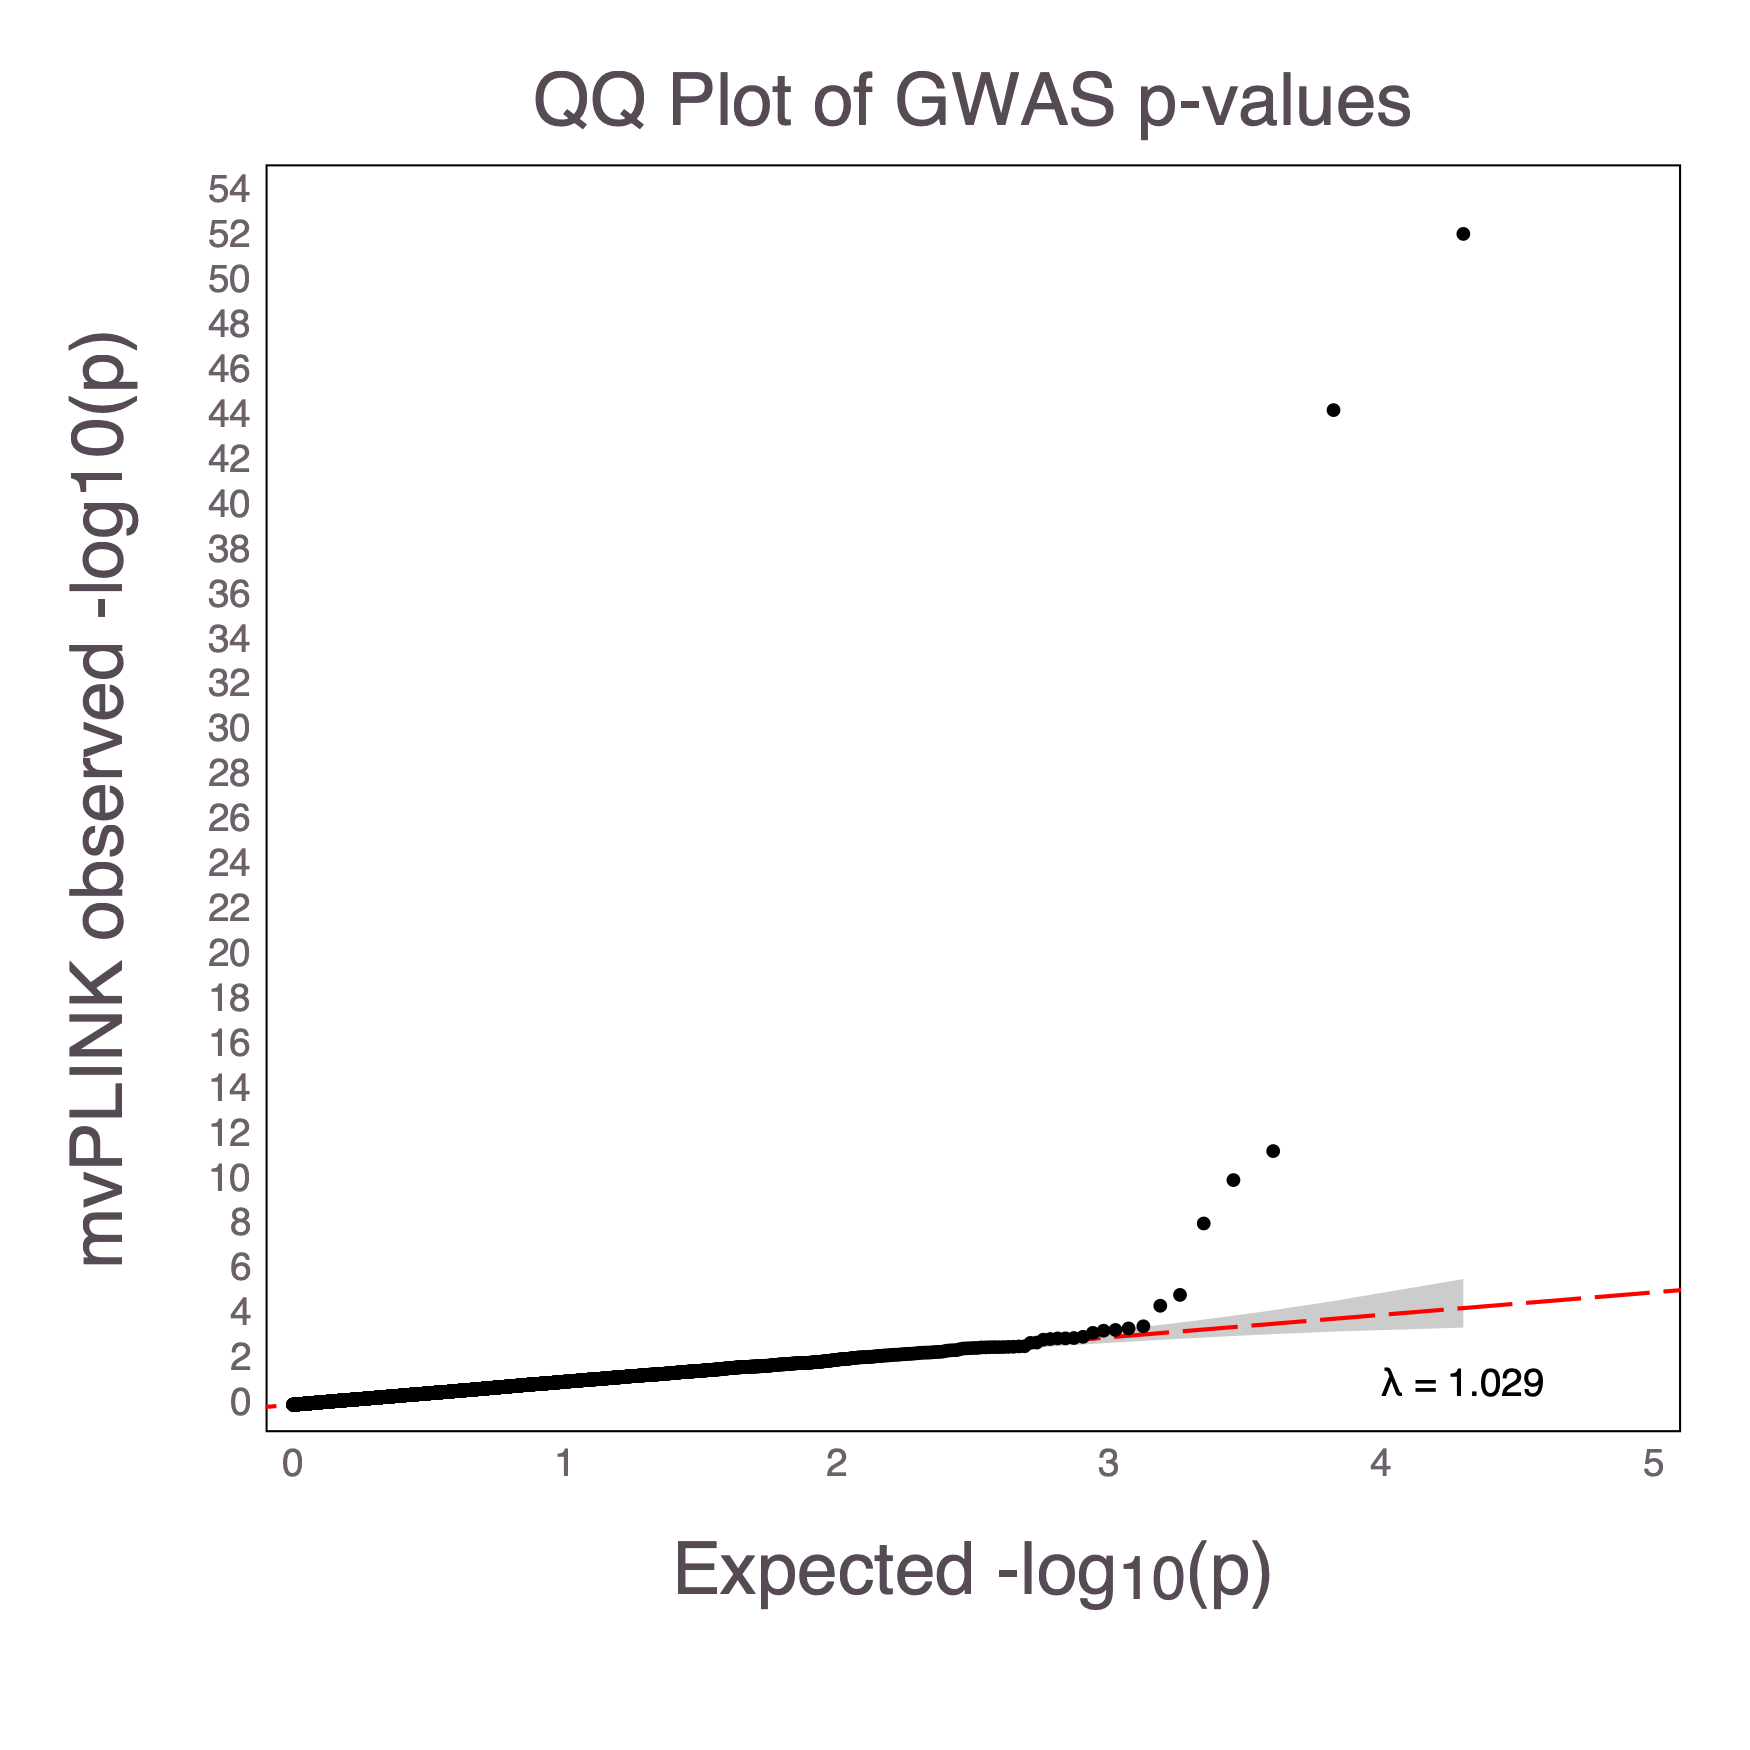

In [22]:
# mvPLINK QQ plots (polygenic)
filename = "plink.mqfam.polygenic.total"
mvplink_df = CSV.read(filename, DataFrame, delim=' ', ignorerepeated=true)
if eltype(mvplink_df[!, :P]) == Float64
    pval = mvplink_df[!, :P]
else
    mvplink_df[findall(x -> x == "NA", mvplink_df[!, :P]), :P] .= "1.0"
    pval = parse.(Float64, mvplink_df[!, :P])
end
pval[findall(iszero, pval)] .= 1e-10
qq(pval, ylabel="mvPLINK observed -log10(p)")
display("image/png", read("qqplot.png"))

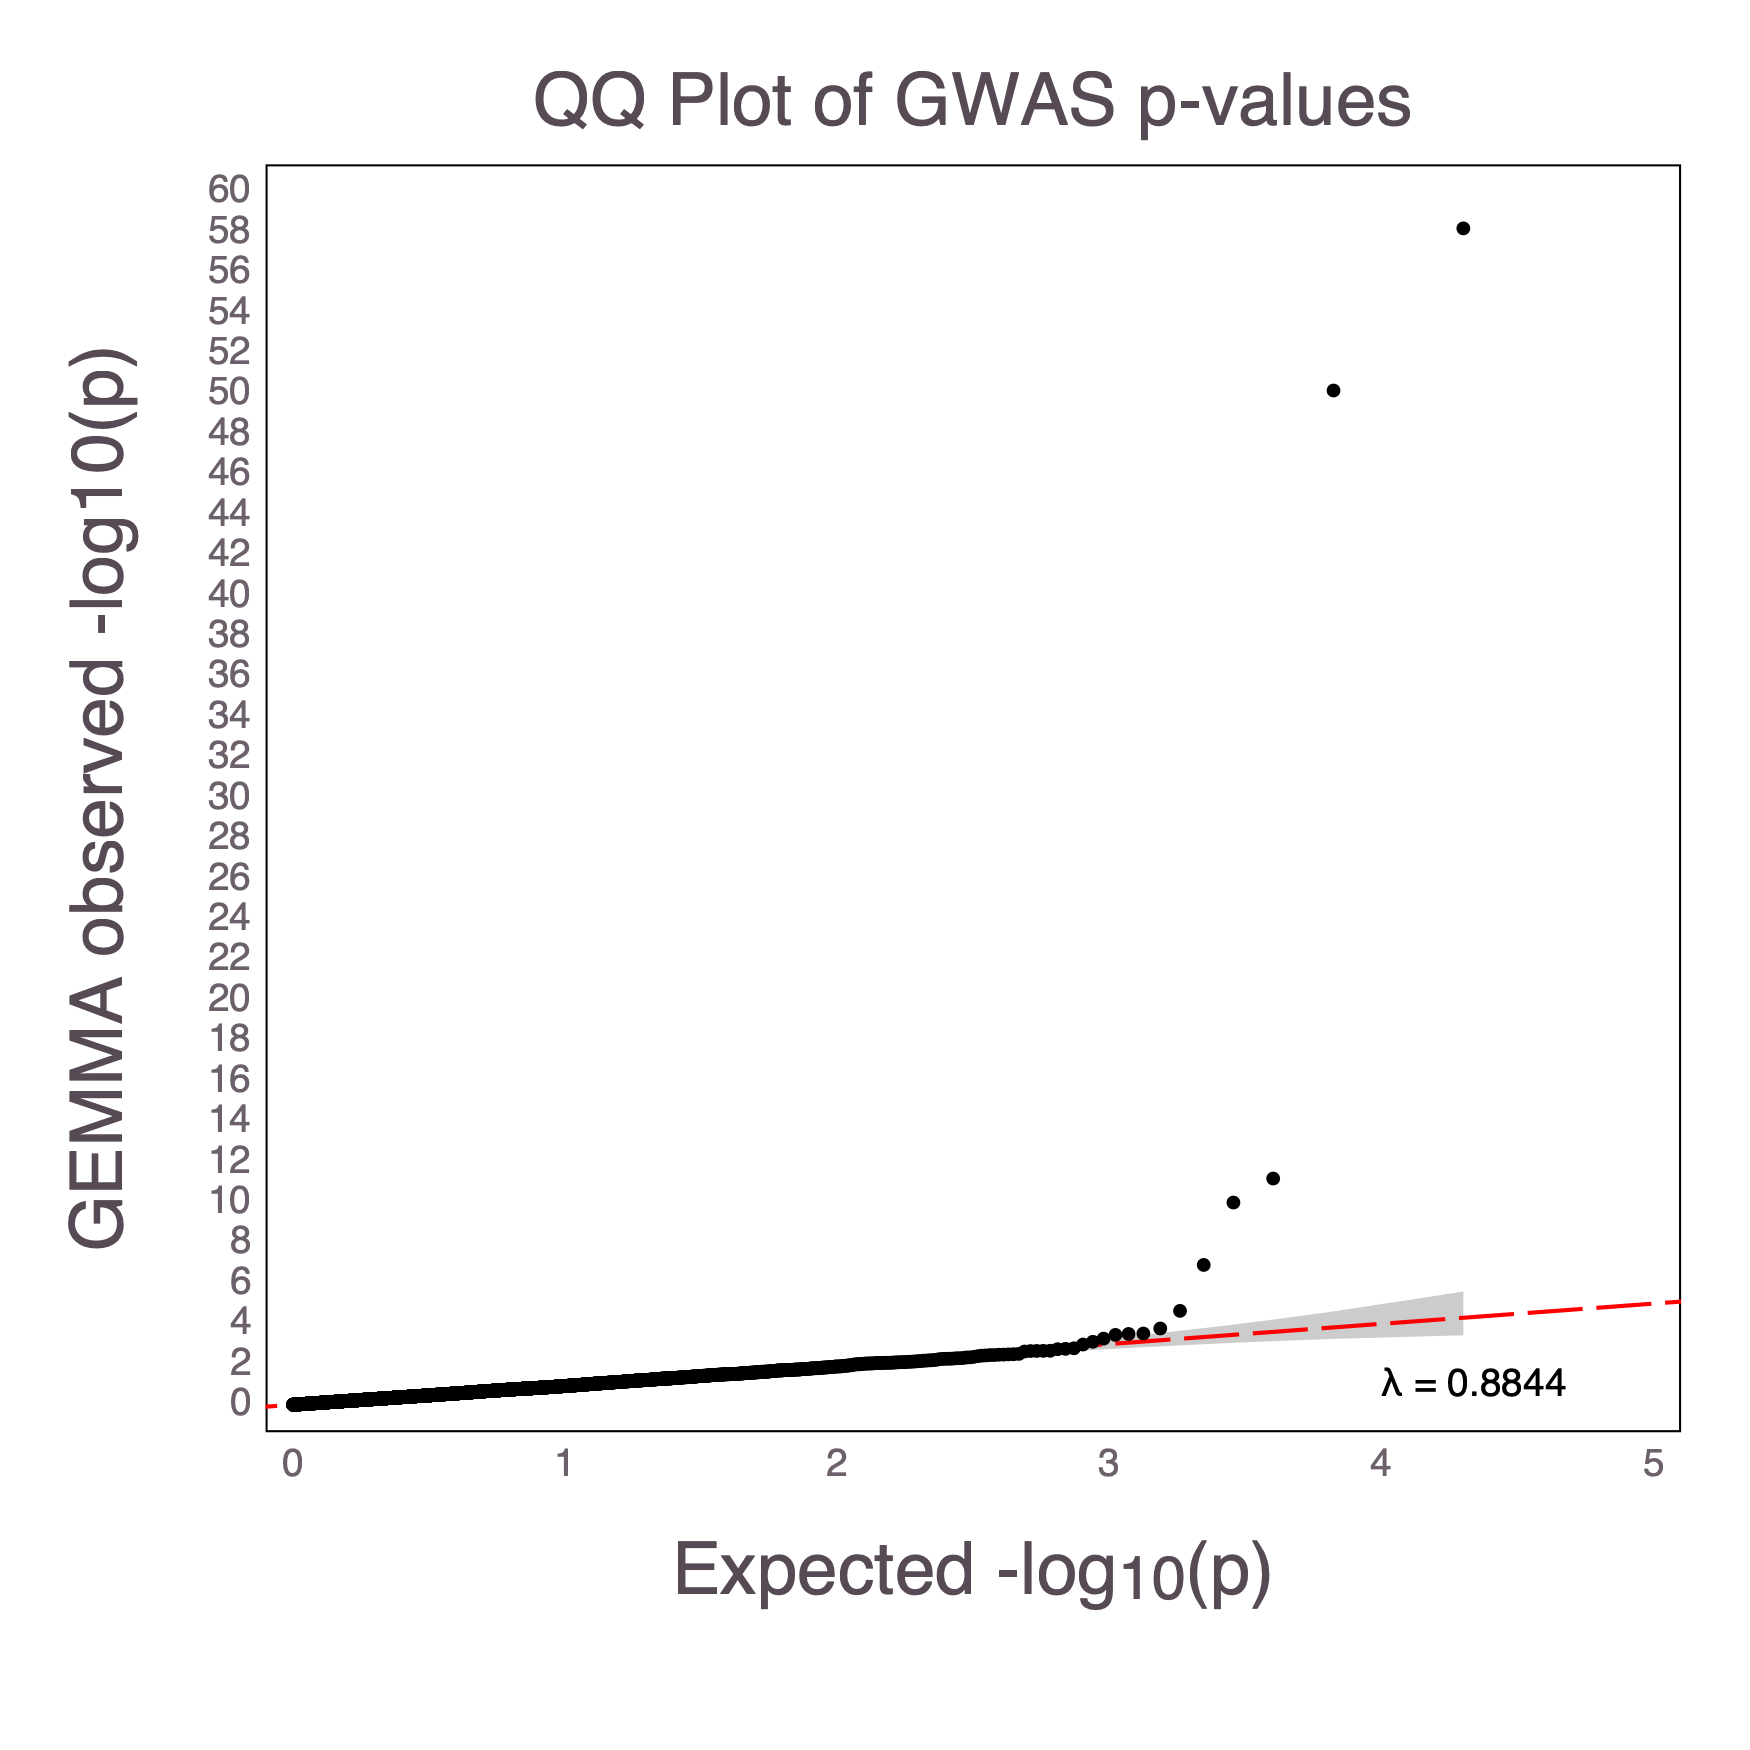

In [21]:
# GEMMA QQ plots (polygenic model)
sim = 2
filename = "gemma.polygenic.result.assoc.txt"
gemma_df = CSV.read(filename, DataFrame)
pval_wald = gemma_df[!, :p_wald]
pval_wald[findall(iszero, pval_wald)] .= 1e-10
qq(pval_wald, ylabel="GEMMA observed -log10(p)")
display("image/png", read("qqplot.png"))